# Modeling

This notebook uses a wide variety of modeling algorithms for a binary classification problem. It reads a file created from a feature selection process that has a reasonably small number of good variables, and we know their order of multivariate importance because we used a proper wrapper method. We can explore # input variables, model algorithms and tune model hyperparameters. At the end we can select our favorite algorithm, run it again and build the final model performace score percentile tables.

Here we call the larger fraction population the goods and the smaller fraction the bads. This notebook was originally
written for fraud detection but can be used for any binary classification. It uses detection rate as an appropriate measure of goodness.

Rather than use a built-in CV, we do a "manual CV" by running each model multiple (nitermax) times and average the performance on the training (trn), testing (tst) and out of time (oot) data sets.

Some of the ML algorithms are very fast and some are slow. Feel free to comment out any cells/models you want. At the bottom of the notebook you can select your final model/hyperparameters to run one time only and then make the business perfoemance tables for that final model.

Things to add: better calculation of FDR@3% when building a model using sampled training data. Right now I just approximate it by using the entire population trntst for a model built with sampled data.

In [1]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [5]:
%%time
vars = pd.read_csv('vars_keep_sorted_FS_300.csv')
print(vars.shape)
vars.head()

(20, 3)
Wall time: 57.7 ms


,wrapper order,variable,filter score
0,1,card_merch_total_14,0.628354
1,2,Card_Merchnum_desc_max_60,0.583893
2,3,card_zip3_variability_max_7,0.375468
3,4,card_zip3_max_30,0.612029
4,5,Cardnum_max_0,0.527913


In [3]:
df = pd.read_csv('candidate_variables.csv')

In [6]:
vars_keep_list = vars.variable.tolist()

In [7]:
vars_keep_list.append('Recnum')
vars_keep_list.append('Fraud')

In [8]:
df_keep = df.filter(vars_keep_list, axis=1)
# df_keep = df[df.index.isin(vars_keep_list)]
print(df_keep.shape)

(96397, 22)


In [9]:
df_keep.to_csv('vars_final.csv',index=False)

In [2]:
vars = pd.read_csv('vars_final_2.csv')
print(vars.shape)
vars.head()

(96397, 22)


,card_zip_total_14,card_zip3_max_30,card_merch_total_0,Card_Merchdesc_avg_60,merch_zip_total_14,Card_Merchnum_desc_avg_3,Merchnum_desc_avg_0,Card_Merchnum_desc_avg_0,Card_Merchnum_desc_avg_7,Card_Merchdesc_avg_14,...,Card_Merchdesc_avg_1,Card_Merchnum_desc_avg_1,Card_Merchdesc_avg_0,Card_Merchdesc_avg_3,Merchnum_desc_avg_1,Merchnum_avg_1,card_merch_avg_30,card_merch_avg_3,Recnum,Fraud
0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,1,0
1,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,...,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,2,0
2,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,...,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,3,0
3,3.62,3.62,3.62,3.62,7.24,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,4,0
4,7.24,3.62,7.24,3.62,10.86,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,5,0


In [3]:
# set the number of variables desired here, and set the names of the y and record number properly
NVARS = 10

# vars.rename(columns={'record':'Recnum'},inplace=True)
# vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list

['Recnum',
 'Fraud',
 'card_zip_total_14',
 'card_zip3_max_30',
 'card_merch_total_0',
 'Card_Merchdesc_avg_60',
 'merch_zip_total_14',
 'Card_Merchnum_desc_avg_3',
 'Merchnum_desc_avg_0',
 'Card_Merchnum_desc_avg_0',
 'Card_Merchnum_desc_avg_7',
 'Card_Merchdesc_avg_14']

In [4]:
final_vars_list

['Recnum',
 'Fraud',
 'card_zip_total_14',
 'card_zip3_max_30',
 'card_merch_total_0',
 'Card_Merchdesc_avg_60',
 'merch_zip_total_14',
 'Card_Merchnum_desc_avg_3',
 'Merchnum_desc_avg_0',
 'Card_Merchnum_desc_avg_0',
 'Card_Merchnum_desc_avg_7',
 'Card_Merchdesc_avg_14']

In [5]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,Recnum,Fraud,card_zip_total_14,card_zip3_max_30,card_merch_total_0,Card_Merchdesc_avg_60,merch_zip_total_14,Card_Merchnum_desc_avg_3,Merchnum_desc_avg_0,Card_Merchnum_desc_avg_0,Card_Merchnum_desc_avg_7,Card_Merchdesc_avg_14
0,1,0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
1,2,0,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42
2,3,0,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49
3,4,0,3.62,3.62,3.62,3.62,7.24,3.62,3.62,3.62,3.62,3.62
4,5,0,7.24,3.62,7.24,3.62,10.86,3.62,3.62,3.62,3.62,3.62


In [6]:
vars.shape

(96397, 12)

In [7]:
vars['Fraud'].sum()

1059

In [8]:
vars.head(10)

,Recnum,Fraud,card_zip_total_14,card_zip3_max_30,card_merch_total_0,Card_Merchdesc_avg_60,merch_zip_total_14,Card_Merchnum_desc_avg_3,Merchnum_desc_avg_0,Card_Merchnum_desc_avg_0,Card_Merchnum_desc_avg_7,Card_Merchdesc_avg_14
0,1,0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
1,2,0,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42
2,3,0,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49
3,4,0,3.62,3.62,3.62,3.62,7.24,3.62,3.62,3.62,3.62,3.62
4,5,0,7.24,3.62,7.24,3.62,10.86,3.62,3.62,3.62,3.62,3.62
5,6,0,3.67,3.67,3.67,3.67,14.53,3.67,3.67,3.67,3.67,3.67
6,7,0,3.62,3.62,3.62,3.62,18.15,3.62,3.62,3.62,3.62,3.62
7,8,0,230.32,230.32,230.32,230.32,230.32,230.32,230.32,230.32,230.32,230.32
8,9,0,62.11,62.11,62.11,62.11,62.11,62.11,62.11,62.11,62.11,62.11
9,10,0,10.86,3.62,10.86,3.62,21.77,3.62,3.62,3.62,3.62,3.62


In [9]:
vars.shape

(96397, 12)

In [10]:
vars.describe()

,Recnum,Fraud,card_zip_total_14,card_zip3_max_30,card_merch_total_0,Card_Merchdesc_avg_60,merch_zip_total_14,Card_Merchnum_desc_avg_3,Merchnum_desc_avg_0,Card_Merchnum_desc_avg_0,Card_Merchnum_desc_avg_7,Card_Merchdesc_avg_14
count,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000
mean,48365.481820,0.010986,806.656625,591.548408,528.698464,404.969385,4242.473674,398.162500,395.402895,395.808621,399.833630,402.025227
std,27945.003883,0.104236,4186.923501,1136.743057,2621.824270,775.188118,8705.804985,797.781065,764.493328,796.983198,793.316401,788.088396
min,1.000000,0.000000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
25%,24154.000000,0.000000,85.000000,69.450000,46.530000,46.000000,283.240000,36.390000,39.920000,35.000000,38.450000,40.490000
50%,48365.000000,0.000000,257.000000,255.850000,159.110000,173.856000,1378.730000,146.630000,158.375000,141.075000,150.275000,158.420000
75%,72578.000000,0.000000,718.640000,717.810000,493.450000,473.010833,5053.000000,441.320000,451.000000,435.190000,447.220000,453.600000
max,96753.000000,1.000000,306633.410000,47900.000000,217467.180000,28392.840000,319334.680000,28392.840000,28392.840000,28392.840000,28392.840000,28392.840000


In [11]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0
1,0
2,0
3,0
4,0


## Scale and truncate field values

In [12]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,card_zip_total_14,card_zip3_max_30,card_merch_total_0,Card_Merchdesc_avg_60,merch_zip_total_14,Card_Merchnum_desc_avg_3,Merchnum_desc_avg_0,Card_Merchnum_desc_avg_0,Card_Merchnum_desc_avg_7,Card_Merchdesc_avg_14
count,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000
mean,806.656625,591.548408,528.698464,404.969385,4242.473674,398.162500,395.402895,395.808621,399.833630,402.025227
std,4186.923501,1136.743057,2621.824270,775.188118,8705.804985,797.781065,764.493328,796.983198,793.316401,788.088396
min,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
25%,85.000000,69.450000,46.530000,46.000000,283.240000,36.390000,39.920000,35.000000,38.450000,40.490000
50%,257.000000,255.850000,159.110000,173.856000,1378.730000,146.630000,158.375000,141.075000,150.275000,158.420000
75%,718.640000,717.810000,493.450000,473.010833,5053.000000,441.320000,451.000000,435.190000,447.220000,453.600000
max,306633.410000,47900.000000,217467.180000,28392.840000,319334.680000,28392.840000,28392.840000,28392.840000,28392.840000,28392.840000


In [13]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [14]:
# use this to cap variables. For some problems it helps
Clip = 10

In [15]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
# Now redo the zscaling after clipping
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()
X.describe()

,card_zip_total_14,card_zip3_max_30,card_merch_total_0,Card_Merchdesc_avg_60,merch_zip_total_14,Card_Merchnum_desc_avg_3,Merchnum_desc_avg_0,Card_Merchnum_desc_avg_0,Card_Merchnum_desc_avg_7,Card_Merchdesc_avg_14
count,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04
mean,-1.385046e-15,6.821759e-15,-1.095524e-15,-3.715469e-15,2.059411e-15,5.642951e-15,6.965341e-15,9.048648e-15,3.080757e-15,1.529972e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.926586e-01,-5.203800e-01,-2.016491e-01,-5.224014e-01,-4.873143e-01,-4.990749e-01,-5.171960e-01,-4.966210e-01,-5.039901e-01,-5.101144e-01
25%,-1.723596e-01,-4.592932e-01,-1.839057e-01,-4.630739e-01,-4.547809e-01,-4.534734e-01,-4.649915e-01,-4.527180e-01,-4.555353e-01,-4.587496e-01
50%,-1.312794e-01,-2.953160e-01,-1.409661e-01,-2.981385e-01,-3.289465e-01,-3.152901e-01,-3.100457e-01,-3.196223e-01,-3.145764e-01,-3.091090e-01
75%,-2.102179e-02,1.110731e-01,-1.344425e-02,8.777411e-02,9.310182e-02,5.409692e-02,7.272412e-02,4.941306e-02,5.973199e-02,6.544288e-02
max,7.304331e+01,4.161754e+01,8.274333e+01,3.610462e+01,3.619335e+01,3.509068e+01,3.662221e+01,3.512876e+01,3.528606e+01,3.551735e+01


In [16]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this oot record number to whatever is appropriate for your data
oot_recnum=84300
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]

## Explore regularization

Solve a linear regression with ridge and lasso regularization and watch how the variable weights evolve with the regularization strength

In [17]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.metrics import mean_squared_error

In [18]:
alphas = 10**np.linspace(2,9,30)*0.5

In [19]:
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

In [20]:
ridge = Ridge()
coefs = []
for a in alphas: 
    ridge.set_params(alpha=a) 
    ridge.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(ridge.coef_) 
np.shape(coefs)

(30, 10)

Wall time: 792 ms


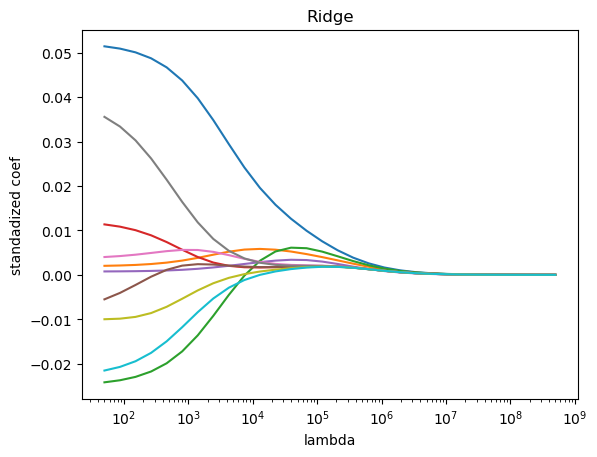

In [21]:
%%time
%matplotlib inline
ax = plt.gca() # Get the current Axes instance
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('lambda') 
plt.ylabel('standadized coef') 
plt.title('Ridge')
plt.savefig('ridge.png')

In [22]:
alphas = 10**np.linspace(-5,0,30)*0.5

In [23]:
%%time
# sometimes this cell takes a long time
lasso = Lasso(max_iter=10000) 
coefs = [] 
for a in alphas: 
    lasso.set_params(alpha=a) 
    lasso.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(lasso.coef_) 
# print('Shape:',np.shape(coefs)
print('Selected Features:', list(vars.columns[np.where(lasso.coef_!=0)[0]]))

Selected Features: []
Wall time: 6.16 s


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


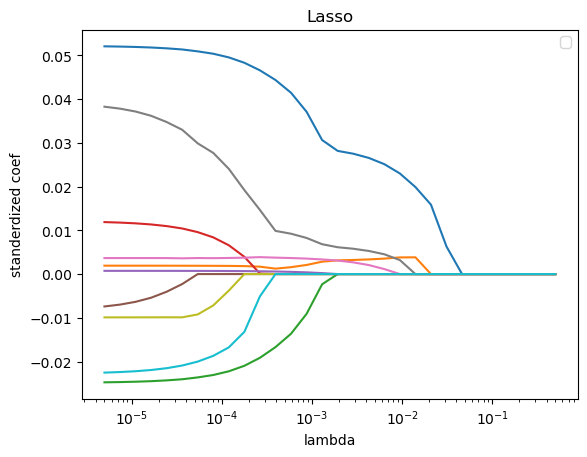

In [24]:
%matplotlib inline
ax = plt.gca() # Get the current Axes instance 
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('lambda')
plt.ylabel('standerdized coef') 
plt.title('Lasso')
plt.legend()
plt.savefig('lasso.png')

## Look at PCA

In [25]:
len(X_trntst.columns)

10

In [26]:
X_trntst_save = X_trntst.copy()

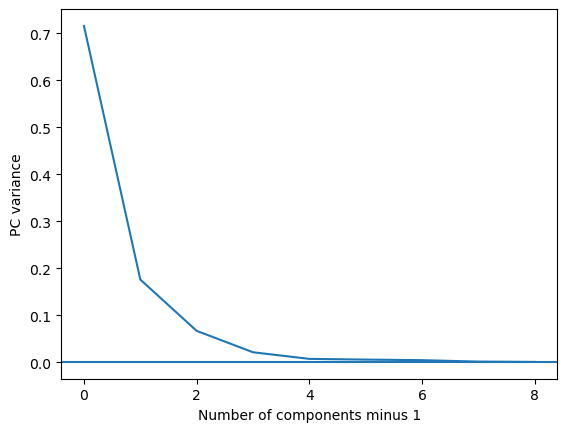

In [27]:
pca = PCA(n_components = .999, svd_solver = 'full')
pca.fit(X_trntst)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
X_trntst = X_trntst_save.copy()

In [28]:
# We look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 6, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-1.416052,0.040744,-0.351630,-0.100100,0.026942,0.009150
1,-1.328526,0.016224,-0.350061,-0.102474,0.026510,0.009016
2,-0.865488,-0.113491,-0.341762,-0.115036,0.024223,0.008305
3,-1.415990,0.040937,-0.351268,-0.100098,0.026942,0.009134
4,-1.415359,0.042333,-0.351655,-0.100577,0.026959,0.008822


In [29]:
princ_comps = pca.transform(X_oot)
X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)
X_oot_orig_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
84300,-0.568276,0.040544,-0.494497,1.005282,-0.289327,-0.168586
84301,-1.247904,0.039724,-0.369895,-0.013360,0.009827,0.020209
84302,5.082517,-1.452790,0.325164,-0.271400,-0.005249,-0.024942
84303,-0.797765,-0.132463,-0.340548,-0.116873,0.023889,0.008201
84304,0.486577,-0.352382,-0.093630,-0.130317,0.083114,-0.026699


In [30]:
X_trntst.describe()

,card_zip_total_14,card_zip3_max_30,card_merch_total_0,Card_Merchdesc_avg_60,merch_zip_total_14,Card_Merchnum_desc_avg_3,Merchnum_desc_avg_0,Card_Merchnum_desc_avg_0,Card_Merchnum_desc_avg_7,Card_Merchdesc_avg_14
count,84300.000000,84300.000000,84300.000000,84300.000000,84300.000000,84300.000000,84300.000000,84300.000000,84300.000000,84300.000000
mean,0.002181,0.002981,0.002052,0.002396,0.015471,0.003227,0.002825,0.003128,0.003180,0.002895
std,1.055618,1.010112,1.055071,0.995537,1.041215,0.999987,0.995271,0.999372,0.999489,0.998218
min,-0.192659,-0.520380,-0.201649,-0.522401,-0.487314,-0.499075,-0.517196,-0.496621,-0.503990,-0.510114
25%,-0.172360,-0.461673,-0.184451,-0.465718,-0.454004,-0.455278,-0.467883,-0.455168,-0.458097,-0.460513
50%,-0.131064,-0.297251,-0.141390,-0.298757,-0.319755,-0.315450,-0.309228,-0.319955,-0.314400,-0.309109
75%,-0.021087,0.116925,-0.014260,0.091262,0.118354,0.057456,0.076612,0.052417,0.063126,0.068428
max,73.043311,41.617542,82.743334,36.104618,36.193345,35.090677,36.622212,35.128760,35.286055,35.517354


In [31]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,12097.000000,12097.000000,12097.000000,12097.000000,12097.000000,12097.000000
mean,-0.084449,-0.052854,-0.098438,-0.001112,0.001921,0.002547
std,2.550353,0.793695,0.525401,0.499787,0.258958,0.181821
min,-1.425172,-23.962330,-2.999253,-5.510214,-8.287893,-4.468552
25%,-1.185448,-0.194159,-0.345516,-0.129137,-0.006419,-0.015601
50%,-0.779219,-0.000163,-0.298029,-0.104308,0.022759,0.006027
75%,0.116564,0.126127,-0.055130,-0.049919,0.026920,0.009367
max,84.266357,10.955449,5.037032,19.671119,4.566189,3.346243


In [32]:
# zscale the PCs
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

In [33]:
X_trntst_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,8.430000e+04,8.430000e+04,8.430000e+04,8.430000e+04,8.430000e+04,8.430000e+04
mean,6.402365e-16,-4.903393e-16,5.664706e-17,-4.010579e-16,1.399956e-16,-1.144646e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-5.256635e-01,-1.855885e+01,-2.678812e+01,-2.555346e+01,-3.203928e+01,-3.845232e+01
25%,-4.521406e-01,-1.309165e-01,-4.142575e-01,-2.734605e-01,-1.634204e-02,-7.247478e-02
50%,-2.870514e-01,1.051345e-02,-3.272084e-01,-2.195681e-01,8.416747e-02,2.069610e-02
75%,6.664427e-02,1.832385e-01,1.173397e-01,-1.118252e-01,1.001760e-01,3.738347e-02
max,3.309324e+01,6.828104e+01,3.802966e+01,4.307059e+01,5.243919e+01,5.018169e+01


In [34]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,12097.000000,12097.000000,12097.000000,12097.000000,12097.000000,12097.000000
mean,-0.031099,-0.039239,-0.118586,-0.002370,0.007007,0.010416
std,0.939197,0.589237,0.632936,1.065080,0.944347,0.743596
min,-0.524836,-17.789573,-3.613118,-11.742650,-30.223661,-18.275079
25%,-0.436555,-0.144143,-0.416233,-0.275201,-0.023409,-0.063802
50%,-0.286957,-0.000121,-0.359028,-0.222289,0.082997,0.024648
75%,0.042926,0.093636,-0.066414,-0.106380,0.098172,0.038309
max,31.032070,8.133298,6.067974,41.920522,16.651634,13.685163


In [35]:
X_trntst_pca.shape

(84300, 6)

In [36]:
X_oot_orig_pca.shape

(12097, 6)

## Subsample the larger class if desired

In [37]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))

0.01043890865954923
(1751, 10) 1751


In [38]:
niter = 0
nitermax = 5
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

In [39]:
import random

## Models

c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


0 0.6290849673202614 0.6156716417910447 0.4581005586592179
1 0.6191247974068071 0.6577946768060836 0.4301675977653631


c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2 0.6309719934102141 0.6410256410256411 0.41899441340782123


c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


3 0.640194489465154 0.6159695817490495 0.44692737430167595
4 0.6360759493670886 0.5725806451612904 0.46368715083798884
loop trn tst oot 1 0.631090439393905 0.6206084373066219 0.44357541899441344


c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


0 0.6199021207177814 0.6254681647940075 0.46368715083798884


c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


1 0.6414473684210527 0.6323529411764706 0.4301675977653631
2 0.6270358306188925 0.6090225563909775 0.441340782122905


c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


3 0.615257048092869 0.6173285198555957 0.44692737430167595
4 0.628099173553719 0.6218181818181818 0.4860335195530726
loop trn tst oot 2 0.626348308280863 0.6211980728070466 0.4536312849162011


c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


0 0.6411483253588517 0.5928853754940712 0.46368715083798884
1 0.6283783783783784 0.6284722222222222 0.4301675977653631


c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


2 0.6396103896103896 0.5757575757575758 0.48044692737430167
3 0.6353135313531353 0.6204379562043796 0.4581005586592179


c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


4 0.6096345514950167 0.6510791366906474 0.48044692737430167
loop trn tst oot 3 0.6308170352391543 0.6137264532737793 0.46256983240223465


c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


0 0.6217532467532467 0.6363636363636364 0.4134078212290503


c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


1 0.6313213703099511 0.599250936329588 0.441340782122905


c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


2 0.6013289036544851 0.6474820143884892 0.4581005586592179


c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


3 0.6264274061990212 0.6067415730337079 0.4581005586592179


c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


4 0.6126543209876543 0.625 0.46368715083798884
loop trn tst oot 4 0.6186970495808717 0.6229676320230844 0.44692737430167606


c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


0 0.6270358306188925 0.631578947368421 0.46368715083798884


c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


1 0.5933014354066986 0.6798418972332015 0.441340782122905


c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


2 0.630718954248366 0.6268656716417911 0.46368715083798884
3 0.622792937399679 0.6381322957198443 0.4245810055865922


c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


4 0.6339869281045751 0.5932835820895522 0.45251396648044695
loop trn tst oot 5 0.6215672171556423 0.633940478810562 0.44916201117318444


c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


0 0.6258169934640523 0.6492537313432836 0.4301675977653631


c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


1 0.6308186195826645 0.6498054474708171 0.4581005586592179


c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


2 0.6136363636363636 0.6590909090909091 0.43575418994413406
3 0.6258503401360545 0.5958904109589042 0.48044692737430167


c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


4 0.6022544283413849 0.6756756756756757 0.45251396648044695
loop trn tst oot 6 0.619675349032104 0.6459432349079179 0.45139664804469276
0 0.6288 0.6078431372549019 0.41899441340782123


c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


1 0.6231647634584013 0.599250936329588 0.44692737430167595


c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


2 0.6216216216216216 0.6334661354581673 0.46368715083798884


c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


3 0.6246006389776357 0.6299212598425197 0.48044692737430167


c:\Users\trivi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


4 0.6079077429983526 0.6410256410256411 0.441340782122905
loop trn tst oot 7 0.6212189534112023 0.6223014219821636 0.45027932960893857


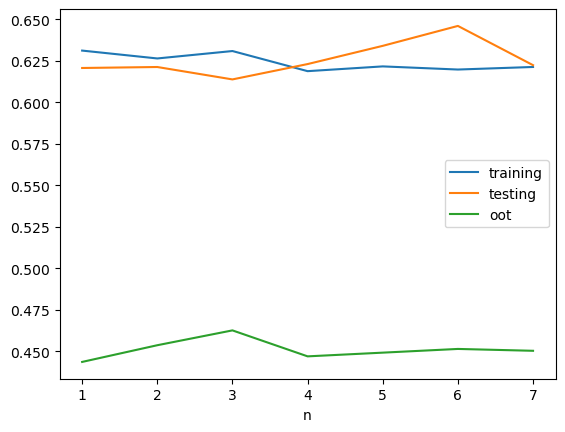

In [40]:
training = []
testing = []
oot = []
variables = []
solver = []
l_ratio = []
model_type = 'Logistic'


# niter = 0
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
for i in range(1,8,1):
    var = random.choice([5, 10, 15])
    solv = random.choice(['lbfgs', 'liblinear'])
    lrat = random.choice([0.1, 0.2])
    for niter in range(nitermax):

        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
        
        model = LogisticRegression(max_iter=50, penalty='l2', C = 1, solver = solv, l1_ratio=lrat)
        
        model.fit(X_trn, Y_trn.values.ravel()) 

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    variables.append(var)
    solver.append(solv)
    l_ratio.append(lrat)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

table=pd.DataFrame({'n': range(1,len(training)+1),'training':training,'testing':testing,'oot':oot})
table.set_index('n',inplace=True) 
table.plot()
plt.savefig('complexity_'+ model_type + '.pdf', format='pdf')
plt.xlabel('n')
plt.show()
# table['']
table['solver'] = solver
table['l_ratio'] = lrat


You can comment in/out any of these model cells and just explore one model type. You can also just rerun that single cell multiple times (hit shift-enter on that cell) as you manually explore different model hyperparameters.

In [61]:
table

table.to_csv('Table.csv', mode = 'a')

0 0.7516556291390728 0.7391304347826086 0.5586592178770949
1 0.7472353870458136 0.6963562753036437 0.5642458100558659
2 0.7328881469115192 0.7295373665480427 0.5586592178770949
3 0.7334437086092715 0.7210144927536232 0.4581005586592179
4 0.7431781701444623 0.7392996108949417 0.5307262569832403
loop trn tst oot 1 0.7416802083700278 0.725067636056572 0.5340782122905028
0 0.7608346709470305 0.7470817120622568 0.5698324022346368
1 0.7610759493670886 0.7217741935483871 0.5418994413407822
2 0.7583333333333333 0.7 0.553072625698324
3 0.7659574468085106 0.7509293680297398 0.5418994413407822
4 0.7340764331210191 0.6944444444444444 0.553072625698324
loop trn tst oot 2 0.7560555667153963 0.7228459436169656 0.5519553072625698
0 0.7951612903225806 0.7846153846153846 0.44692737430167595
1 0.7871621621621622 0.7222222222222222 0.4245810055865922
2 0.7756410256410257 0.73046875 0.5698324022346368
3 0.7671009771986971 0.6954887218045113 0.3407821229050279
4 0.7779578606158833 0.7034220532319392 0.25698

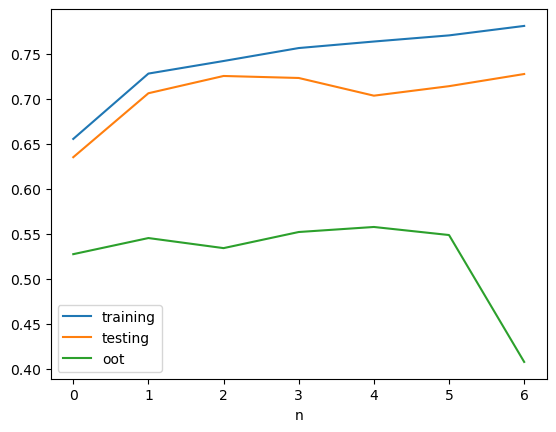

In [41]:
training = []
testing = []
oot = []
depth = []
sample = []
criteria = []
lf = []
model_type = 'Decision'
# niter = 0
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
for i in range(1,8,1):
    max_depth = random.choice([10, 20, 50, 100])
    sample_split = random.choice([20, 50, 100, 500, 1000])
    leaf = random.choice([20, 50, 100, 500])
    crit = random.choice(['gini', 'entropy'])
    for niter in range(nitermax):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
        
        model = DecisionTreeClassifier(max_depth=max_depth,min_samples_split=sample_split,min_samples_leaf=leaf, criterion=crit)        
        model.fit(X_trn, Y_trn.values.ravel()) 

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    depth.append(max_depth)
    sample.append(sample_split)
    criteria.append(crit)
    lf.append(leaf)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

table=pd.DataFrame({'training':training,'testing':testing,'oot':oot})
# table.set_index('n',inplace=True)
table = table.sort_values(by = 'training').reset_index()
table.drop('index', axis = 1, inplace=True)
table.plot()
plt.savefig('complexity_'+ model_type + '.pdf', format='pdf')
plt.xlabel('n')
plt.show()
table['Max_depth'] = depth
table['Sample_split'] = sample
table['criteria'] = criteria
table['leaf'] = lf
table.to_csv('Table.csv', mode = 'a')


In [63]:
table

,training,testing,oot,Max_depth,Sample_split,criteria,leaf
0,0.659385,0.638017,0.411173,100,100,entropy,20
1,0.756845,0.732417,0.498324,10,500,entropy,50
2,0.758295,0.730970,0.446927,10,1000,gini,20
3,0.772669,0.726814,0.410056,50,500,entropy,100
4,0.784230,0.733553,0.474860,100,20,entropy,20
5,0.887376,0.748436,0.402235,20,100,gini,500
6,0.952514,0.756356,0.316201,10,100,gini,20


0 0.6378466557911908 0.6292134831460674 0.5083798882681564
1 0.6167192429022083 0.6585365853658537 0.5083798882681564
2 0.6417445482866043 0.6050420168067226 0.5083798882681564
3 0.6366612111292962 0.6282527881040892 0.5139664804469274
4 0.6447811447811448 0.6118881118881119 0.5139664804469274
loop trn tst oot 2 0.6355505605780889 0.6265865970621689 0.5106145251396648
0 0.6183574879227053 0.6602316602316602 0.5083798882681564
1 0.628099173553719 0.64 0.5139664804469274
2 0.6355140186915887 0.5966386554621849 0.5139664804469274
3 0.6264274061990212 0.6591760299625468 0.5251396648044693
4 0.6418152350081038 0.6045627376425855 0.5083798882681564
loop trn tst oot 2 0.6300426642750276 0.6321218166597955 0.5139664804469273
0 0.6385350318471338 0.626984126984127 0.5139664804469274
1 0.6448445171849427 0.6356877323420075 0.5139664804469274
2 0.6256077795786061 0.6387832699619772 0.5139664804469274
3 0.6292134831460674 0.6264591439688716 0.5139664804469274
4 0.6490939044481054 0.589743589743589

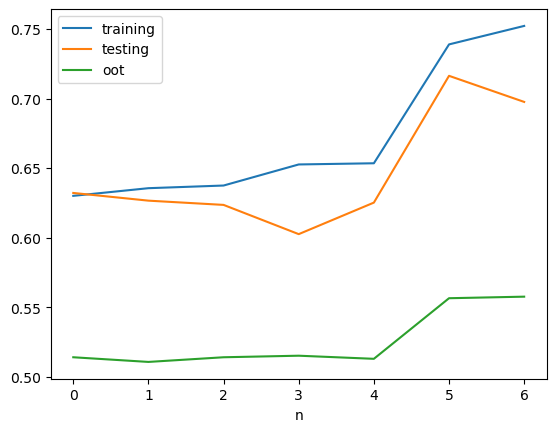

In [42]:
training = []
testing = []
oot = []
depth = [2, 2, 10, 10, 10, 20, 20]
sample = []
criteria = []
lf = []
nest = []
model_type = 'Random Forest'
# niter = 0
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
for i in [2, 2, 10, 10, 10, 20, 20]:
    n_est = random.choice([50, 100])
    sample_split = random.choice([100, 500, 1000])
    leaf = random.choice([100, 500, 1000])
    crit = random.choice(['gini', 'entropy'])
    for niter in range(nitermax):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
        
        model = RandomForestClassifier(n_estimators=n_est,max_depth=i,min_samples_split=sample_split,min_samples_leaf=leaf,max_features=10, criterion=crit)        
        model.fit(X_trn, Y_trn.values.ravel()) 

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    # depth.append(max_depth)
    sample.append(sample_split)
    criteria.append(crit)
    nest.append(n_est)
    lf.append(leaf)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

table=pd.DataFrame({'training':training,'testing':testing,'oot':oot})
# table.set_index('n',inplace=True)
table = table.sort_values(by = 'training').reset_index()
table.drop('index', axis = 1, inplace=True)
table.plot()
plt.savefig('complexity_'+ model_type + '.pdf', format='pdf')
plt.xlabel('n')
plt.show()
table['Max_depth'] = depth
table['Sample_split'] = sample
table['criteria'] = criteria
table['leaf'] = lf
table['N estimators'] = nest
table.to_csv('Table.csv', mode = 'a')


0 0.6443719412724307 0.6292134831460674 0.5139664804469274
1 0.6420168067226891 0.6210526315789474 0.5083798882681564
2 0.6548956661316212 0.6342412451361867 0.4972067039106145
3 0.6403785488958991 0.6300813008130082 0.5139664804469274
4 0.6433224755700325 0.6390977443609023 0.5139664804469274
loop trn tst oot 1 0.6449970877185345 0.6307372810070223 0.5094972067039106
0 0.7644230769230769 0.7734375 0.5195530726256983
1 0.7375643224699828 0.7609427609427609 0.5418994413407822
2 0.7454242928452579 0.7060931899641577 0.547486033519553
3 0.7358184764991896 0.7604562737642585 0.5027932960893855
4 0.752442996742671 0.7330827067669173 0.5586592178770949
loop trn tst oot 2 0.7471346330960357 0.7468024862876189 0.5340782122905028
0 0.6242138364779874 0.6639344262295082 0.41899441340782123
1 0.6194398682042833 0.6410256410256411 0.40782122905027934
2 0.6354679802955665 0.6309963099630996 0.4245810055865922
3 0.6175040518638574 0.6387832699619772 0.39664804469273746
4 0.6373801916932907 0.6102362

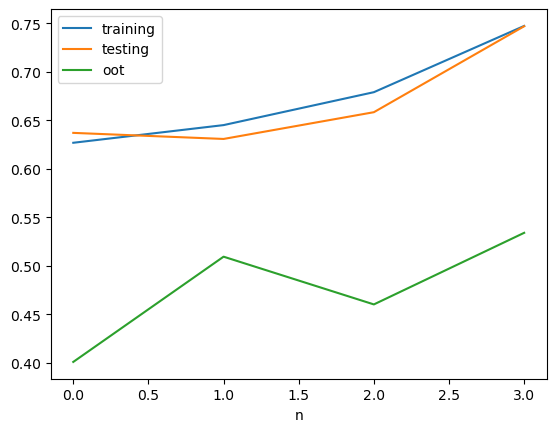

In [43]:
training = []
testing = []
oot = []
depth = [1, 2, 10, 15]
sample = []
criteria = []
lf = []
nest = []
model_type = 'LGBM'
# niter = 0
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
for i in [1, 2, 10, 15]:
    n_est = random.choice([5, 10, 20, 50])
    learn = random.choice([0.1, 0.01, 0.001])
    leaf = random.choice([2, 10, 50])
    crit = random.choice(['gini', 'entropy'])
    for niter in range(nitermax):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
        
        model = lgb.LGBMClassifier(n_estimators=n_est,max_depth=i,num_leaves=leaf, learning_rate=learn)        
        model.fit(X_trn, Y_trn.values.ravel()) 

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    # depth.append(max_depth)
    sample.append(sample_split)
    criteria.append(learn)
    nest.append(n_est)
    lf.append(leaf)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

table=pd.DataFrame({'training':training,'testing':testing,'oot':oot})
# table.set_index('n',inplace=True)
table = table.sort_values(by = 'training').reset_index()
table.drop('index', axis = 1, inplace=True)
table.plot()
plt.savefig('complexity_'+ model_type + '.pdf', format='pdf')
plt.xlabel('n')
plt.show()
table['Max_depth'] = depth
# table['Sample_split'] = sample
table['Learning Rate'] = criteria
table['leaf'] = lf
table['N estimators'] = nest
table.to_csv('Table.csv', mode = 'a')

0 0.6252158894645942 0.6245847176079734 0.5139664804469274
1 0.6451077943615257 0.592057761732852 0.5139664804469274
2 0.6323529411764706 0.6194029850746269 0.5139664804469274
3 0.6280587275693311 0.6217228464419475 0.5083798882681564
4 0.6449511400651465 0.5864661654135338 0.5139664804469274
loop trn tst oot 2 0.6351372985274135 0.6088468952541868 0.5128491620111733
0 0.6235864297253635 0.6475095785440613 0.5027932960893855
1 0.653160453808752 0.5703422053231939 0.5083798882681564
2 0.613747954173486 0.6691449814126395 0.5195530726256983
3 0.659432387312187 0.5622775800711743 0.5139664804469274
4 0.617124394184168 0.6666666666666666 0.5139664804469274
loop trn tst oot 2 0.6334103238407913 0.623188202403547 0.511731843575419
0 0.6372549019607843 0.6455223880597015 0.5139664804469274
1 0.6535947712418301 0.6268656716417911 0.5139664804469274
2 0.6556291390728477 0.6666666666666666 0.5139664804469274
3 0.6483333333333333 0.5857142857142857 0.5139664804469274
4 0.6372549019607843 0.615671

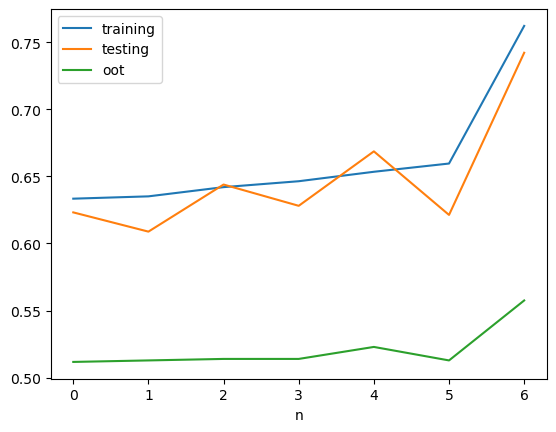

In [44]:
training = []
testing = []
oot = []
depth = [2, 2, 10, 10, 10, 20, 20]
sample = []
criteria = []
lf = []
nest = []
model_type = 'Random Forest'
# niter = 0
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
for i in [2, 2, 10, 10, 10, 20, 20]:
    n_est = random.choice([50, 100])
    sample_split = random.choice([100, 500, 1000])
    leaf = random.choice([100, 500, 1000])
    crit = random.choice(['gini', 'entropy'])
    for niter in range(nitermax):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
        
        model = RandomForestClassifier(n_estimators=n_est,max_depth=i,min_samples_split=sample_split,min_samples_leaf=leaf,max_features=10, criterion=crit)        
        model.fit(X_trn, Y_trn.values.ravel()) 

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    # depth.append(max_depth)
    sample.append(sample_split)
    criteria.append(crit)
    nest.append(n_est)
    lf.append(leaf)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

table=pd.DataFrame({'training':training,'testing':testing,'oot':oot})
# table.set_index('n',inplace=True)
table = table.sort_values(by = 'training').reset_index()
table.drop('index', axis = 1, inplace=True)
table.plot()
plt.savefig('complexity_'+ model_type + '.pdf', format='pdf')
plt.xlabel('n')
plt.show()
table['Max_depth'] = depth
table['Sample_split'] = sample
table['criteria'] = criteria
table['leaf'] = lf
table['N estimators'] = nest
table.to_csv('Table.csv', mode = 'a')

0 0.7897350993377483 0.75 0.49162011173184356
1 0.789049919484702 0.8301158301158301 0.5418994413407822
2 0.7784911717495987 0.7704280155642024 0.5083798882681564
3 0.7921875 0.7333333333333333 0.5139664804469274
4 0.784 0.7647058823529411 0.3854748603351955
loop trn tst oot 2 0.7866927381144098 0.7697166122732614 0.488268156424581
0 0.9937205651491365 0.831275720164609 0.3575418994413408
1 0.9936406995230525 0.8286852589641435 0.36312849162011174
2 0.9848993288590604 0.823943661971831 0.35195530726256985
3 0.9903225806451613 0.8038461538461539 0.35195530726256985
4 0.9887096774193549 0.7961538461538461 0.3407821229050279
loop trn tst oot 10 0.990258570319153 0.8167809282201167 0.353072625698324
0 0.995334370139969 0.8523206751054853 0.36312849162011174
1 0.9951845906902087 0.7976653696498055 0.3687150837988827
2 0.9936908517350158 0.8170731707317073 0.33519553072625696
3 0.998371335504886 0.8120300751879699 0.3575418994413408
4 0.9919093851132686 0.8244274809160306 0.36312849162011174

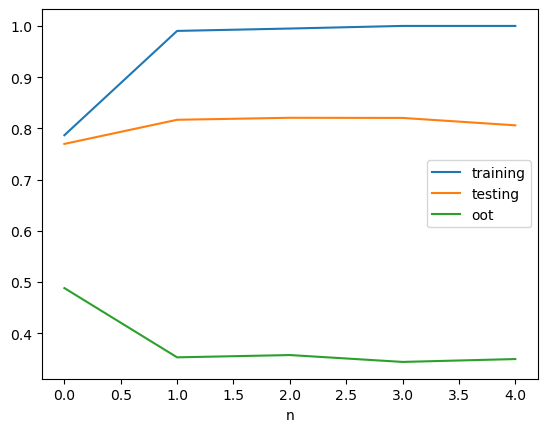

In [45]:
training = []
testing = []
oot = []
depth = [2, 10, 10, 20, 20]
sample = []
criteria = []
lf = []
nest = []
lr = []
model_type = 'XGB'
# niter = 0
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
for i in [2, 10, 10, 20, 20]:
    n_est = random.choice([50, 100])
    sample_split = random.choice([100, 500, 1000])
    leaf = random.choice([100, 500, 1000])
    learn = random.choice([0.01, 0.1, 0.001])
    for niter in range(nitermax):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
        
        model = xgb.XGBClassifier(n_estimators=n_est,max_depth=i)        
        model.fit(X_trn, Y_trn.values.ravel()) 

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    # depth.append(max_depth)
    sample.append(sample_split)
    criteria.append(crit)
    nest.append(n_est)
    lr.append(learn)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

table=pd.DataFrame({'training':training,'testing':testing,'oot':oot})
# table.set_index('n',inplace=True)
table = table.sort_values(by = 'training').reset_index()
table.drop('index', axis = 1, inplace=True)
table.plot()
plt.savefig('complexity_'+ model_type + '.pdf', format='pdf')
plt.xlabel('n')
plt.show()
table['Max_depth'] = depth
# table['Sample_split'] = sample
# table['criteria'] = criteria
# table['Learning Rate'] = lr
table['N estimators'] = nest
table.to_csv('Table.csv', mode = 'a')

In [46]:
training = []
testing = []
oot = []
depth = [2, 5, 10, 10, 15, 20]
sample = []
criteria = []
lr = []
nest = []
model_type = 'Catboost'
# niter = 0
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
for i in [2, 5, 10, 10, 15, 20]:
    n_est = random.choice([50, 100])
    sample_split = random.choice([100, 500, 1000])
    leaf = random.choice([100, 500, 1000])
    learn = random.choice([0.1, 0.01, 0.001])
    for niter in range(nitermax):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
        
        model = CatBoostClassifier(max_depth=i, learning_rate=learn)        
        model.fit(X_trn, Y_trn.values.ravel()) 

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    depth.append(max_depth)
    # sample.append(sample_split)
    # criteria.append(crit)
    # nest.append(n_est)
    lr.append(learn)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

table=pd.DataFrame({'training':training,'testing':testing,'oot':oot})
# table.set_index('n',inplace=True)
table = table.sort_values(by = 'training').reset_index()
table.drop('index', axis = 1, inplace=True)
table.plot()
plt.savefig('complexity_'+ model_type + '.pdf', format='pdf')
plt.xlabel('n')
plt.show()
table['Max_depth'] = depth
# table['Sample_split'] = sample
# table['criteria'] = criteria
table['Learning Rate'] = lr
# table['N estimators'] = nest
table.to_csv('Table.csv', mode = 'a')

0:	learn: 0.6671167	total: 176ms	remaining: 2m 55s
1:	learn: 0.6412192	total: 184ms	remaining: 1m 31s
2:	learn: 0.6183191	total: 195ms	remaining: 1m 4s
3:	learn: 0.5948841	total: 201ms	remaining: 50s
4:	learn: 0.5730595	total: 206ms	remaining: 41.1s
5:	learn: 0.5525778	total: 212ms	remaining: 35.2s
6:	learn: 0.5311395	total: 219ms	remaining: 31s
7:	learn: 0.5117141	total: 226ms	remaining: 28s
8:	learn: 0.4932334	total: 232ms	remaining: 25.6s
9:	learn: 0.4742029	total: 238ms	remaining: 23.6s
10:	learn: 0.4567699	total: 245ms	remaining: 22s
11:	learn: 0.4390951	total: 251ms	remaining: 20.6s
12:	learn: 0.4237834	total: 256ms	remaining: 19.5s
13:	learn: 0.4089715	total: 262ms	remaining: 18.5s
14:	learn: 0.3941938	total: 268ms	remaining: 17.6s
15:	learn: 0.3800761	total: 274ms	remaining: 16.8s
16:	learn: 0.3664079	total: 280ms	remaining: 16.2s
17:	learn: 0.3539259	total: 286ms	remaining: 15.6s
18:	learn: 0.3414996	total: 293ms	remaining: 15.2s
19:	learn: 0.3289539	total: 300ms	remaining: 14

In [ ]:
training = []
testing = []
oot = []
depth = [2, 5, (10, 10), 20, (20, 20, 20)]
sample = []
activation = []
lf = []
nest = []
al = []
model_type = 'Neural Net'
# niter = 0
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
for i in [2, 5, (10, 10), 20, (20, 20, 20)]:
    n_est = random.choice([50, 100])
    sample_split = random.choice([100, 500, 1000])
    leaf = random.choice(['adam', 'sgd'])
    act = random.choice(['relu', 'logistic'])
    alpha = random.choice([0.1, 0.01, 0.001])
    for niter in range(nitermax):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
        
        # model = RandomForestClassifier(n_estimators=n_est,max_depth=i,min_samples_split=sample_split,min_samples_leaf=leaf,max_features=10, criterion=crit)        
        model = MLPClassifier(hidden_layer_sizes=i, activation=act, alpha=0.1, learning_rate='adaptive', learning_rate_init=alpha, solver = leaf)

        model.fit(X_trn, Y_trn.values.ravel()) 

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    # depth.append(max_depth)
    sample.append(sample_split)
    criteria.append(act)
    nest.append(alpha)
    lf.append(leaf)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

table=pd.DataFrame({'training':training,'testing':testing,'oot':oot})
# table.set_index('n',inplace=True)
table = table.sort_values(by = 'training').reset_index()
table.drop('index', axis = 1, inplace=True)
table.plot()
plt.savefig('complexity_'+ model_type + '.pdf', format='pdf')
plt.xlabel('n')
plt.show()
table['Hidden Layers'] = depth
# table['Sample_split'] = sample
table['Learning Rate'] = criteria
table['Solver'] = lf
table['Alpha'] = nest
table.to_csv('Table.csv', mode = 'a')

In [67]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0

In [68]:
# %%time
# # Logistic regression

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):    
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .4)

#     model = LogisticRegression(max_iter=50, penalty='l2', C = 1, solver = 'lbfgs', l1_ratio=0.2)
 
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['log reg',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [69]:
%%time
# Single DT

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = DecisionTreeClassifier(max_depth=100,min_samples_split=1000,min_samples_leaf=500)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['DT',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1

print(FDR3.mean())
model_counter = model_counter + 1

0 0.639871382636656 0.6744186046511628 0.35195530726256985
1 0.64891846921797 0.6451612903225806 0.43575418994413406
2 0.6611570247933884 0.68 0.3463687150837989
3 0.6671899529042387 0.6172839506172839 0.4860335195530726
4 0.6820428336079077 0.6666666666666666 0.35195530726256985
trn    0.659836
tst    0.656706
oot    0.394413
dtype: float64
Wall time: 2.19 s


In [70]:
%%time
# RF

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = RandomForestClassifier(n_estimators=50,max_depth=10,min_samples_split=1000,min_samples_leaf=500,max_features=10)
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['RF',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.722495894909688 0.7047970479704797 0.547486033519553
1 0.6981757877280266 0.6967509025270758 0.5363128491620112
2 0.6549520766773163 0.6771653543307087 0.41899441340782123
3 0.6934426229508197 0.7037037037037037 0.5363128491620112
4 0.6705107084019769 0.6593406593406593 0.4301675977653631
trn    0.687915
tst    0.688352
oot    0.493855
dtype: float64
Wall time: 56.7 s


In [71]:
%%time
# LGBM

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = lgb.LGBMClassifier(num_leaves=50,n_estimators=100, max_depth = 10, learning_rate= 0.01)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.912396694214876 0.7927272727272727 0.36312849162011174
1 0.9030694668820679 0.842911877394636 0.3743016759776536
2 0.9089430894308943 0.8641509433962264 0.3575418994413408
3 0.9135802469135802 0.8274760383386581 0.4245810055865922
4 0.9295081967213115 0.825925925925926 0.43575418994413406
trn    0.913500
tst    0.830638
oot    0.391061
dtype: float64
Wall time: 1.44 s


In [72]:
%%time
# NN

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = MLPClassifier(hidden_layer_sizes=(10), activation='relu', alpha=0.1, learning_rate='adaptive', learning_rate_init=0.01, solver = 'adam')

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.6878048780487804 0.6679245283018868 0.4581005586592179
1 0.6842105263157895 0.6561264822134387 0.41899441340782123
2 0.6864 0.6392156862745098 0.4301675977653631
3 0.6891025641025641 0.671875 0.441340782122905
4 0.6900958466453674 0.6850393700787402 0.5418994413407822
trn    0.687523
tst    0.664036
oot    0.458101
dtype: float64
Wall time: 8.09 s


In [73]:

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = MLPClassifier(hidden_layer_sizes=(5), solver = 'sgd', activation = 'relu', alpha = 0.1, learning_rate='constant', learning_rate_init=0.01)

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['NN',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [74]:

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = MLPClassifier(hidden_layer_sizes=(10, 10), solver = 'sgd', activation = 'logistic', alpha = 0.01, learning_rate='constant', learning_rate_init=0.001)

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['NN',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [75]:

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = MLPClassifier(hidden_layer_sizes=(20, 20, 20), solver = 'sgd', activation = 'relu', alpha = 0.001, learning_rate='adaptive', learning_rate_init=0.001)

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['NN',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [76]:

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = MLPClassifier(hidden_layer_sizes=(20, 20), activation = 'relu', alpha = 0.1, learning_rate='constant', learning_rate_init=0.001)
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['NN',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [77]:

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = MLPClassifier(hidden_layer_sizes=(10, 10, 10), solver = 'sgd', activation = 'logistic', alpha = 0.001, learning_rate='constant', learning_rate_init=0.0010)

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['NN',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [78]:

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = MLPClassifier(hidden_layer_sizes=(5, 10, 20), solver = 'sgd', activation = 'logistic', alpha = 0.1, learning_rate='constant', learning_rate_init=0.01)
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['NN',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [79]:
# %%time
# # NN on pc's

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = MLPClassifier(hidden_layer_sizes=(2))

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['NN_PCs',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [80]:
# %%time
# # GBC

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = GradientBoostingClassifier(max_depth=30,n_estimators=30, learning_rate=0.001)

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['GBC',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [81]:
# %%time
# # Catboost

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = CatBoostClassifier(verbose=0, max_depth=10, iterations=1000, learning_rate = 0.001)

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['cat boost',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [82]:
# %%time
# # NOTE this cell has been substantially modified to evaluate a sampled trn/tst data set. 
# # Only use this cell if you do downsampling of the goods.
# # each good needs to have a weight of (1-actual_ratio)/sample_ratio_desired
# # it's hard to get the correct FDR@3% for the actual train and test, so I just use the original trntst after the model is built for evaluation

# xmult = actual_good_fraction / (actual_bad_fraction * sample_ratio_desired)
# print(xmult)
# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_sampled, Y_trntst_sampled, test_size = .3)

#     model = CatBoostClassifier(verbose=0, max_depth=5, iterations=10)

#     model.fit(X_trn, Y_trn.values.ravel())  
    
#     X_oot = X_oot_orig.copy()
#     X_trn = X_trntst.copy()
#     Y_trn = Y_trntst.copy()
#     X_tst = X_trntst.copy()
#     Y_tst = Y_trntst.copy()


#     predictions = model.predict_proba(X_trntst)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trntst['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_trntst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_trntst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['cat boost_sampled',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [83]:
# %%time
# # Catboost on pc's

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = CatBoostClassifier(verbose=0, max_depth=2, iterations=5)


#     X_oot = X_oot_orig_pca.copy()
#     # X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['cat boost_PCs',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [84]:
# %%time
# # unsupervised model using pc's. 

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     pow = 2
#     oop = 1/pow
#     predictions = ((X_trn.abs()**pow).sum(axis=1))**oop
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = ((X_tst.abs()**pow).sum(axis=1))**oop
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = ((X_oot.abs()**pow).sum(axis=1))**oop
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['unsupervised outliers',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [85]:
# %%time
# # XGB

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = xgb.XGBClassifier(max_depth=10, min_child_weight = 1,  n_estimators=1000, learning_rate = 0.001, subsample = 0.8)

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['XGB',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [86]:
# %%time
# # Knn
# # Knn can be very slow with a lot of records.

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = KNeighborsClassifier(n_neighbors=50) 
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['Knn',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [87]:
# %%time
# # SVM
# # SVM can be very slow. It scales like the # training records cubed

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = svm.SVC(
#         C=.1, 
# #         gamma=100,
# #         kernel='linear',
#         kernel='poly',
#         probability=True)
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['SVM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

## Model comparison plots

In [88]:
df = Modeling_output.dropna()
df.head(20)

,Model,Trn,Tst,OOT
0,DT,0.639871,0.674419,0.351955
1,DT,0.648918,0.645161,0.435754
2,DT,0.661157,0.68,0.346369
3,DT,0.66719,0.617284,0.486034
4,DT,0.682043,0.666667,0.351955
5,RF,0.722496,0.704797,0.547486
6,RF,0.698176,0.696751,0.536313
7,RF,0.654952,0.677165,0.418994
8,RF,0.693443,0.703704,0.536313
9,RF,0.670511,0.659341,0.430168


In [89]:
df.shape

(20, 4)

In [90]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], var_name=['Type'], value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,DT,Trn,0.639871
1,DT,Trn,0.648918
2,DT,Trn,0.661157
3,DT,Trn,0.66719
4,DT,Trn,0.682043


In [91]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

,Model,Type,Value
0,DT,Trn,0.639871
1,DT,Trn,0.648918
2,DT,Trn,0.661157
3,DT,Trn,0.66719
4,DT,Trn,0.682043


In [92]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

Trn                 Tst                 OOT          
           mean       std      mean       std      mean       std
Model                                                            
DT     0.659836  0.016331  0.656706  0.025705  0.394413  0.063279
LGBM   0.913500  0.009837  0.830638  0.026188  0.391061  0.036420
NN     0.687523  0.002314  0.664036  0.017294  0.458101  0.049022
RF     0.687915  0.026082  0.688352  0.019643  0.493855  0.063525

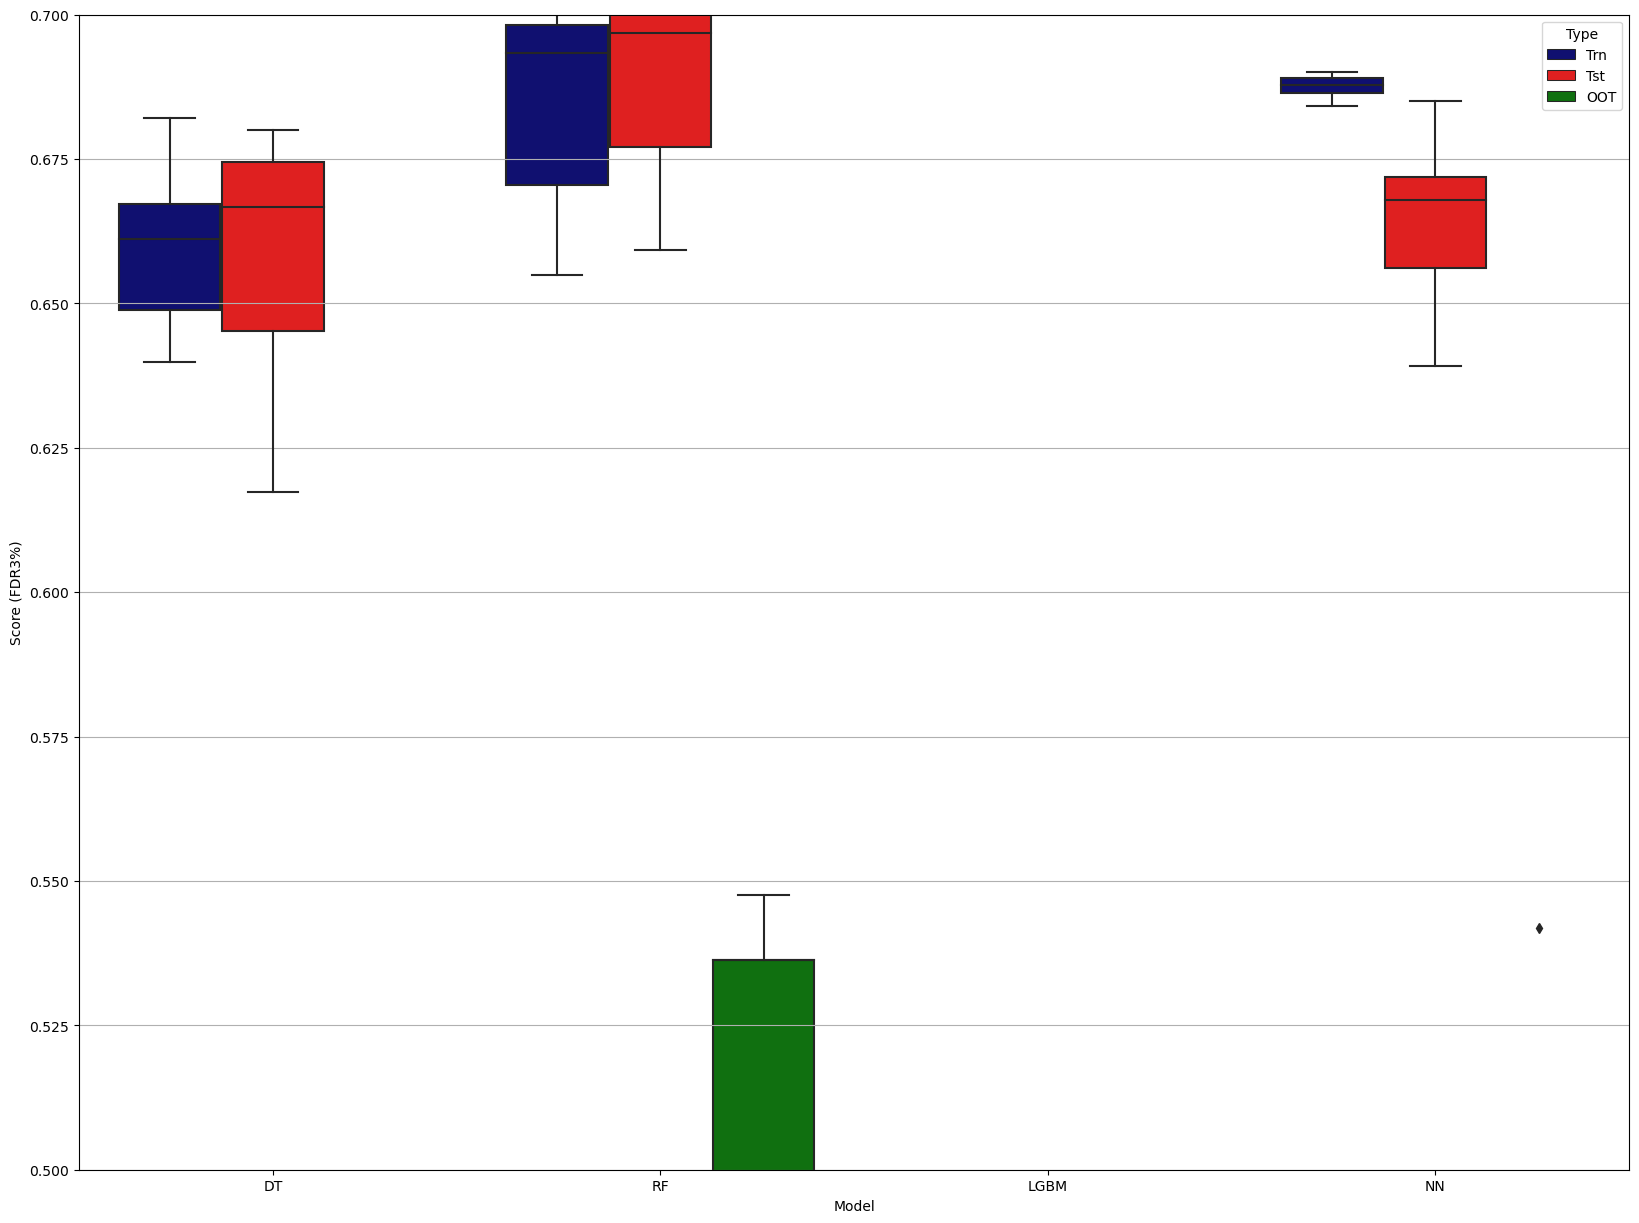

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

plt.ylim(.5,.7)
plt.ylabel('Score (FDR3%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

In [94]:
print('duration: ', datetime.now() - start_time)

duration:  1:11:12.909108


The rest of the notebook makes the tables for your final model of choice. You need to run that final model only once (no CV). If you want you can run the below cell over and over by itself until it gives you a model you like (due to the stochastic nature of some ML algorithms, but you can't change from your best hyperparameters.

In [95]:
%%time

for niter in range(30):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# here's where you put your final model of choice
    model = CatBoostClassifier(verbose=0, iterations=100)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    if(FDR3.loc[niter, 'oot'] > .56): break
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.8716216216216216 0.8298611111111112 0.41899441340782123
1 0.8976 0.8196078431372549 0.36312849162011174
2 0.8843648208469055 0.8609022556390977 0.36312849162011174
3 0.8804347826086957 0.8389830508474576 0.33519553072625696
4 0.898360655737705 0.8074074074074075 0.49162011173184356
5 0.8852459016393442 0.8592592592592593 0.4245810055865922
6 0.8824503311258278 0.8369565217391305 0.44692737430167595
7 0.8808777429467085 0.7851239669421488 0.3687150837988827
8 0.8841059602649006 0.855072463768116 0.5027932960893855
9 0.8633440514469454 0.8449612403100775 0.3575418994413408
10 0.899505766062603 0.8168498168498168 0.4748603351955307
11 0.8858131487889274 0.8211920529801324 0.5418994413407822
12 0.8888888888888888 0.833976833976834 0.40782122905027934
13 0.8679549114331723 0.8185328185328186 0.5027932960893855
14 0.889060092449923 0.8311688311688312 0.33519553072625696
15 0.8846787479406919 0.8315018315018315 0.36312849162011174
16 0.8742038216560509 0.8373015873015873 0.357541899441340

In [96]:
%%time

for niter in range(30):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# here's where you put your final model of choice
    model = lgb.LGBMClassifier(num_leaves=50,n_estimators=100, max_depth = 10, learning_rate= 0.01)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    if(FDR3.loc[niter, 'oot'] > .508): break
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.9174917491749175 0.8394160583941606 0.35195530726256985
1 0.9087893864013267 0.8086642599277978 0.3743016759776536
2 0.9007874015748032 0.8040816326530612 0.4692737430167598
3 0.9158576051779935 0.8015267175572519 0.4245810055865922
4 0.927652733118971 0.8023255813953488 0.44692737430167595
5 0.9221854304635762 0.8115942028985508 0.3743016759776536
6 0.9036334913112164 0.8299595141700404 0.4972067039106145
7 0.9230769230769231 0.8327137546468402 0.329608938547486
8 0.9056316590563166 0.8116591928251121 0.4022346368715084
9 0.9049844236760125 0.8613445378151261 0.35195530726256985
10 0.9183006535947712 0.832089552238806 0.5139664804469274
trn    0.895302
tst    0.828099
oot    0.429423
dtype: float64
Wall time: 3.35 s


In [97]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [98]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((21, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((21, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((21, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)

,card_merch_total_14,Card_Merchnum_desc_max_60,card_zip3_variability_max_7,card_zip3_max_30,Cardnum_max_0,card_merch_total_7,Merchnum_desc_actual/med_60,zip3_avg_3,card_merch_avg_30,zip3_actual/max_30,predicted,Fraud
89055,2.954419,2.823427,4.108099,2.664042,3.027937,3.020595,1.867069,0.234338,1.001004,0.441986,0.634169,1
89057,3.313470,2.823427,3.541580,2.664042,3.027937,3.385305,2.438997,0.291861,1.033614,0.752528,0.634169,1
89091,5.725968,0.793620,3.697704,2.664042,0.881670,5.835831,3.579588,0.829922,1.054958,0.666947,0.634169,1
89060,3.537990,2.823427,4.520519,2.664042,3.027937,3.613365,1.364556,0.313629,1.006241,0.215915,0.630182,1
89121,6.919649,2.823427,3.290347,2.664042,1.553056,7.048328,0.698592,0.867039,0.994621,0.890243,0.630182,1
89112,5.838117,0.793620,5.338219,2.664042,0.881670,5.949747,0.926710,0.808011,1.008574,-0.232313,0.630182,1
89077,5.249519,2.823427,5.232495,2.664042,3.027937,5.351872,0.329103,0.561461,1.183110,-0.174360,0.629714,1
89068,4.294732,2.823427,0.647693,2.664042,3.027937,4.382034,5.031170,0.457454,1.184702,2.338835,0.627532,1
89114,6.341771,2.823427,2.489337,2.664042,1.553056,6.461341,1.338741,0.878185,1.060930,1.329323,0.625675,1
89128,7.032132,2.823427,5.335792,2.664042,1.553056,7.162583,-0.067799,0.847155,0.959545,-0.230983,0.622620,1


In [99]:
for i in range(20):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:,'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:,'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot
    
    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot
    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,121.0,68.0,53.0,56.198347,43.801653,121.0,68.0,53.0,0.570566,29.608939,29.038373,1.283019
2,2.0,121.0,111.0,10.0,91.735537,8.264463,242.0,179.0,63.0,1.501930,35.195531,33.693601,2.841270
3,3.0,121.0,92.0,29.0,76.033058,23.966942,363.0,271.0,92.0,2.273871,51.396648,49.122777,2.945652
4,4.0,121.0,117.0,4.0,96.694215,3.305785,484.0,388.0,96.0,3.255580,53.631285,50.375705,4.041667
5,5.0,121.0,120.0,1.0,99.173554,0.826446,605.0,508.0,97.0,4.262460,54.189944,49.927484,5.237113
6,6.0,121.0,112.0,9.0,92.561983,7.438017,726.0,620.0,106.0,5.202215,59.217877,54.015662,5.849057
7,7.0,121.0,115.0,6.0,95.041322,4.958678,847.0,735.0,112.0,6.167142,62.569832,56.402690,6.562500
8,8.0,121.0,117.0,4.0,96.694215,3.305785,968.0,852.0,116.0,7.148850,64.804469,57.655619,7.344828
9,9.0,121.0,120.0,1.0,99.173554,0.826446,1089.0,972.0,117.0,8.155731,65.363128,57.207398,8.307692


In [100]:
FDR3.to_csv('FDR3_20.csv')

In [101]:
FDR_trn.to_csv('FDR_trn_21.csv', index=False)
FDR_tst.to_csv('FDR_tst_21.csv', index=False)
FDR_oot.to_csv('FDR_oot_21.csv', index=False)

In [102]:
print("duration: ", datetime.now() - start_time)

duration:  1:11:35.606126
